# Merge DataFrames

In [46]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from scipy.stats.mstats import winsorize
import statsmodels.api as sm

import yfinance as yf

from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm  # for progress tracking

import numpy as np
import pandas as pd
import datetime
import calendar

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get ETF Prices

#### Investment Universe below

In [223]:
import sys, os
#sys.path.append(os.path.abspath(".."))  # only if notebook is inside /notebooks
from src import analytics as an
from src.data_loader import (
    load_etf_prices,
    load_fama_french_factors,
    load_volatility_indices,
    load_macro_indicators,
    merge_all_factors,
    get_etf_data
)

# Load each component
#etf_prices = load_etf_prices("data/raw/1d_etf_prices_06_Jun.csv")
tickers = ['AGG','BIL','DBC','EFA','GLD','HYG','MTUM','SPY','TIP','TLT','USMV','VLUE','VNQ']
price_data,dividends = get_etf_data(tickers,'2000-01-01','2025-03-31')
etf_prices =  (1+(price_data.pct_change().fillna(0)+dividends/price_data)).cumprod()
etf_prices.ffill().dropna(inplace = True)


#tgt_index

etf_1mth_fwd_returns = etf_prices.pct_change(20).shift(-20).dropna()
tgt_index = etf_1mth_fwd_returns.index

raw_rets = etf_prices.pct_change().fillna(0)
raw_rets = raw_rets.reindex(index = tgt_index)

[*********************100%***********************]  13 of 13 completed


## Macro Indicators

In [63]:
def last_day_of_month(date_str):
    date = datetime.datetime.strptime(date_str, '%Y-%m-%d')
    last_day = calendar.monthrange(date.year, date.month)[1]  # Get last day of month
    return date.replace(day=last_day)

In [ ]:
#Import and clean macro indicators
filepath = r"C:\Users\kmavy\Documents\mydocs\My Docs\SMU MQF Easy Dean's List\Sem 6 Deans List Easy A+\QF623 Portfolio Mgmt\Proj\data\raw"
median_cpi = 'MedianCPI.csv'
unemployment = 'UNRATE.csv'
ir = 'ir10y.csv'

macro_df = []
for file in [median_cpi,unemployment,ir]:
    f = os.path.join(filepath,file)
    macro_df.append(pd.read_csv(f,index_col = 0).sort_index())
macro_df = pd.concat(macro_df,axis = 1).sort_index()
macro_df.index = [last_day_of_month(dt) for dt in macro_df.index]
macro_df.index.names = ['Date']
macro_df[['UNRATE','REAINTRATREARAT10Y']] = macro_df[['UNRATE','REAINTRATREARAT10Y']].diff()
macro_df = macro_df.fillna(0).dropna()
macro_df = macro_df['2013':]

# Factors

In [123]:
f = os.path.join(filepath,'fffactors.csv')
ff_factors = pd.read_csv(f,index_col = 0)
ff_factors.index = [datetime.datetime.strptime(str(dt),"%Y%m%d") for dt in ff_factors.index]
ff_factors_monthly = ff_factors.rolling(30).sum()#.shift(-30)
#ff_factors.plot()

In [128]:
ff_factors

,Mkt-RF,SMB,HML,RMW,CMA,RF
1963-07-01,-0.67,0.00,-0.34,-0.01,0.16,0.012
1963-07-02,0.79,-0.26,0.26,-0.07,-0.20,0.012
1963-07-03,0.63,-0.17,-0.09,0.18,-0.34,0.012
1963-07-05,0.40,0.08,-0.27,0.09,-0.34,0.012
1963-07-08,-0.63,0.04,-0.18,-0.29,0.14,0.012
...,...,...,...,...,...,...
2025-04-24,2.14,-0.03,-0.95,-1.19,0.03,0.017
2025-04-25,0.64,-0.47,-1.15,0.01,-0.16,0.017
2025-04-28,0.08,0.32,0.14,-0.03,-0.17,0.017
2025-04-29,0.58,-0.07,-0.04,-0.32,-0.14,0.017


In [130]:
#Investigate Correlations
corr = pd.concat([ff_factors_monthly,etf_1mth_fwd_returns],axis = 1).dropna().corr()
corr.iloc[6:,:6]

,Mkt-RF,SMB,HML,RMW,CMA,RF
AGG,-0.115943,-0.083987,-0.092951,0.100007,-0.083535,0.138853
BIL,0.025206,-0.117569,-0.074555,0.018124,-0.155757,0.959659
DBC,0.048183,0.149934,0.184556,0.055509,0.142339,-0.018112
EFA,-0.123069,0.111836,0.009289,0.148017,0.028652,0.040914
GLD,-0.136871,-0.186187,-0.045163,0.083654,0.037279,0.197509
HYG,-0.139729,0.016665,-0.067812,0.097344,-0.032191,0.066774
MTUM,-0.153522,0.094957,-0.021518,0.022507,-0.045266,0.041037
SPY,-0.185985,0.074636,-0.048433,0.060091,-0.001880,0.027240
TIP,-0.156426,-0.076594,-0.045211,0.127075,-0.047626,0.074643
TLT,-0.061606,-0.086085,-0.048760,0.076069,-0.078793,0.043981


### Merge all and research

In [185]:
ff_factors_monthly = ff_factors_monthly.reindex(index = tgt_index).ffill()
macro_df = macro_df.reindex(index = tgt_index).ffill().bfill()
merged = pd.concat([ff_factors_monthly,macro_df],axis = 1).ffill().fillna(0)
merged = sm.add_constant(merged)

In [186]:

lookback_wdw = 250*5

def rolling_lr(fwd_rets,features,lookback_wdw):
    ret_df = []
    for col in fwd_rets.columns:
        ret_preds = [0]
        features_combined = features.copy()
        for i in range(1,len(features)):
            tempY = fwd_rets.iloc[max(i-lookback_wdw,0):i][col]
            tempX = features_combined.iloc[max(i-lookback_wdw,0):i]
            testX = features_combined.iloc[[i]]
            testX = pd.DataFrame(testX)
            
            model = LinearRegression()
            model.fit(tempX,tempY)
            pred = model.predict(testX)
            ret_preds.append(pred[0])
        ret_pred = pd.DataFrame(ret_preds,index = fwd_rets.index,columns = [col])
        ret_df.append(ret_pred)
    return pd.concat(ret_df,axis = 1)

In [187]:
final_pred = rolling_lr(etf_1mth_fwd_returns,merged,lookback_wdw)

In [243]:
wdw = 5*250
n = etf_1mth_fwd_returns.shape[1]
wts = [[1/n]*n]
for i in range(1,len(etf_1mth_fwd_returns.shift(20))):
    train = etf_1mth_fwd_returns.shift(20).iloc[max(0,i-wdw):i]
    optimize = pyf.pyOpt(train)
    ret_pred = final_pred.iloc[i]
    try:
        w = optimize.get_max_sharpe_wts(mu = ret_pred,min_w = 0,max_w = 0.25)
    except:
        w = [1/n]*n
    wts.append(w)
wts = pd.DataFrame(wts)
wts.index = etf_1mth_fwd_returns.index
wts.columns = etf_1mth_fwd_returns.columns    

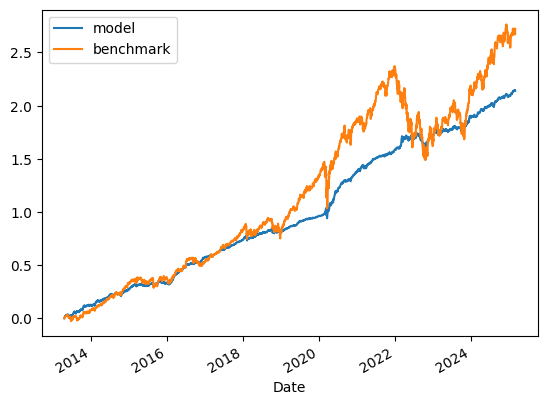

In [251]:
((1+(wts*raw_rets)).cumprod()-1).sum(axis = 1).plot(label = 'model')
((1+(0.6*raw_rets['SPY']+0.4*raw_rets['TLT'])).cumprod()-1).plot(label = 'benchmark')
plt.legend()

In [ ]:
#month_end_preds = final_pred.resample("M").last()
#actual_month_end = etf_1mth_fwd_returns.shift(20).resample("M").last()

In [143]:
import sys, os
#sys.path.append(os.path.abspath(".."))  # only if notebook is inside /notebooks
from src import analytics as an
from src.data_loader import (
    load_etf_prices,
    load_fama_french_factors,
    load_volatility_indices,
    load_macro_indicators,
    merge_all_factors,
    get_etf_data
)

# Load each component
#etf_prices = load_etf_prices("data/raw/1d_etf_prices_06_Jun.csv")
tickers = ['AGG','BIL','DBC','EFA','GLD','HYG','MTUM','SPY','TIP','TLT','USMV','VLUE','VNQ']
price_data,dividends = get_etf_data(tickers,'2000-01-01','2025-03-31')
etf_prices =  (1+(price_data.pct_change().fillna(0)+dividends/price_data)).cumprod()
ff_factors = load_fama_french_factors("data/raw/merged_FF_factors.csv")
vix = load_volatility_indices("data/raw/vix_vvix_data.csv")
macro = load_macro_indicators("data/raw/wide_format_leading_indicators.csv")

#Clean Macro
tenyr = yf.download("^TNX")[['Close']]
tenyr.columns =['10 Year']
tenyr = pd.concat([tenyr,macro],axis = 1).dropna()[['10 Year']]
macro = pd.concat([macro,tenyr],axis = 1)
macro['10 Year'] = macro['10 Year'].ffill()#.diff().fillna(0)
macro['10 Year Chg'] = macro['10 Year'].diff(30).fillna(0)


# Merge
merged = merge_all_factors(etf_prices, ff_factors, vix, macro)
merged.to_csv("data/processed/merged_factors.csv")

print("ETF prices:", etf_prices.shape)
print("Merged macro + factors:", merged.shape)
display(merged.head())


[*********************100%***********************]  13 of 13 completed
[*********************100%***********************]  1 of 1 completed

✅ Latest common end date (earliest of last dates): 2025-03-28
✅ Earliest common start date (latest of first dates): 2014-01-01
⚠️ Dropping 3 row(s) with remaining NAs after forward fill:
[datetime.date(2014, 1, 1), datetime.date(2014, 1, 2), datetime.date(2014, 1, 3)]

📆 Final merged date range: 2014-01-06 to 2025-03-28
📐 Shape: (2969, 17)
🧩 Columns: ['10Y_Yield_Constant_Maturity', '20Y_Yield_Constant_Maturity', 'Building_Permits_Contribution', 'Consumer_Confidence_Expectations', 'Consumer_Confidence_Index', 'PMI_Manufacturing_Global', 'PMI_Services_Business_Activity_US', 'Unemployment_Initial_Claims', '10 Year', '10 Year Chg', 'QMJ', 'MKT-Rf', 'SMB', 'HML', 'UMD', 'VIX', 'VVIX']
❓ Any NAs: False
ETF prices: (6348, 13)
Merged macro + factors: (2969, 17)


,10Y_Yield_Constant_Maturity,20Y_Yield_Constant_Maturity,Building_Permits_Contribution,Consumer_Confidence_Expectations,Consumer_Confidence_Index,PMI_Manufacturing_Global,PMI_Services_Business_Activity_US,Unemployment_Initial_Claims,10 Year,10 Year Chg,QMJ,MKT-Rf,SMB,HML,UMD,VIX,VVIX
Date,,,,,,,,,,,,,,,,,
2014-01-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12200.0,2.961,0.0,-0.000385,-0.003754,-0.001534,0.001975,-0.002097,-0.21,-1.699997
2014-01-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12200.0,2.961,0.0,0.000704,0.006735,-0.000883,-0.002411,0.005060,-0.63,0.000000
2014-01-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12200.0,2.961,0.0,-0.002832,-0.000792,-0.000735,-0.000363,0.000417,-0.05,0.000000
2014-01-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12200.0,2.961,0.0,0.002088,-0.005052,0.001843,-0.000827,0.000702,0.02,0.000000
2014-01-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-12200.0,2.961,0.0,-0.001331,0.008189,-0.000209,-0.000475,-0.006920,-0.75,-0.590004


In [217]:
import pandas as pd
from src.return_calculator import (
    extract_close_prices,
    compute_log_returns,
    generate_forward_returns,
    save_returns
)



# Step 2: Compute log returns
returns = compute_log_returns(etf_prices)

# Step 3: Compute next-period returns as target
targets = generate_forward_returns(returns, horizon=1)

# Step 4: Save if needed
save_returns(returns, "data/processed/etf_log_returns.csv")
save_returns(targets, "data/processed/etf_target_returns.csv")

print(returns.isnull().values.any()) ## False
print(targets.isnull().values.any()) ## False

targets = targets.reindex(index = merged.index)
targets = targets.ffill().fillna(0)
#merged = merged.diff().ffill().fillna(0)


False
False


## Investigate Macro factors

In [218]:
macro.corr()

,10Y_Yield_Constant_Maturity,20Y_Yield_Constant_Maturity,Building_Permits_Contribution,Consumer_Confidence_Expectations,Consumer_Confidence_Index,PMI_Manufacturing_Global,PMI_Services_Business_Activity_US,Unemployment_Initial_Claims,10 Year,10 Year Chg
10Y_Yield_Constant_Maturity,1.000000,0.969191,0.016204,0.164635,0.147669,0.160882,0.179852,-0.125268,0.138681,0.371118
20Y_Yield_Constant_Maturity,0.969191,1.000000,-0.022435,0.150643,0.118339,0.169885,0.152176,-0.114169,0.144861,0.363863
Building_Permits_Contribution,0.016204,-0.022435,1.000000,0.070661,0.182244,0.077115,0.114257,-0.014385,-0.017834,-0.014030
Consumer_Confidence_Expectations,0.164635,0.150643,0.070661,1.000000,0.777381,0.009044,0.046539,-0.168823,0.022535,0.029000
Consumer_Confidence_Index,0.147669,0.118339,0.182244,0.777381,1.000000,0.341475,0.214129,0.034464,0.030760,0.114087
PMI_Manufacturing_Global,0.160882,0.169885,0.077115,0.009044,0.341475,1.000000,0.382146,0.074827,-0.054542,-0.065563
PMI_Services_Business_Activity_US,0.179852,0.152176,0.114257,0.046539,0.214129,0.382146,1.000000,-0.074407,0.000405,0.006222
Unemployment_Initial_Claims,-0.125268,-0.114169,-0.014385,-0.168823,0.034464,0.074827,-0.074407,1.000000,0.014783,0.017871
10 Year,0.138681,0.144861,-0.017834,0.022535,0.030760,-0.054542,0.000405,0.014783,1.000000,0.397478
10 Year Chg,0.371118,0.363863,-0.014030,0.029000,0.114087,-0.065563,0.006222,0.017871,0.397478,1.000000


<Axes: >

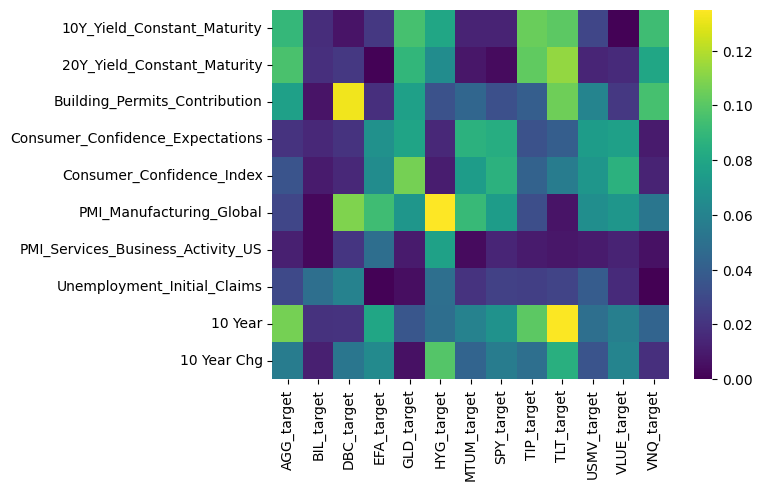

In [224]:
macro = merged[macro.columns]
df = pd.concat([targets,macro],axis = 1).iloc[:250*2]
#sns.pairplot(df)
cmat = df.corr().iloc[13:,:13]
sns.heatmap(abs(round(cmat,3)),cmap = 'viridis')

prediction_macro_linear = an.rolling_model(targets,macro,250*5,model ='linear',perform_PCA=True)
pred_macro_rsq= an.rolling_model(targets,macro,250*5,model ='linear',perform_PCA=True,return_type = 'rsq')

In [ ]:
macro_predictions = []
macro_rsqs = []
for col in targets.columns:
    features = macro
    pred = an.rolling_model(targets[[col]],features,250*4,'linear')
    rsqs = an.rolling_model(targets[[col]],features,250*4,'linear',return_type = 'rsq')
    macro_predictions.append(pred)
    macro_rsqs.append(rsqs)

<Axes: xlabel='Date'>

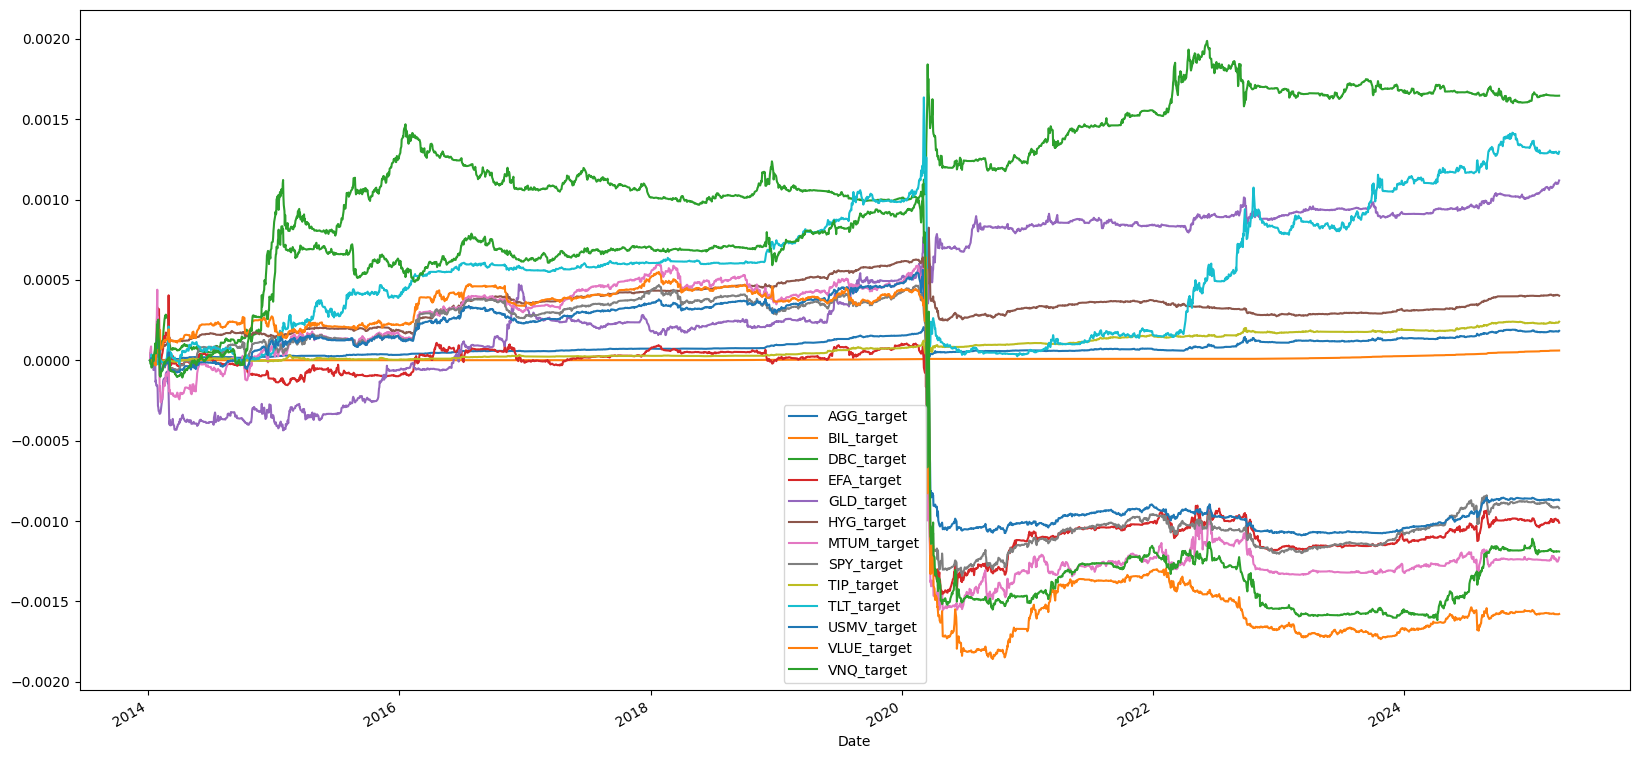

In [ ]:
(pd.concat(macro_predictions,axis = 1)*targets).cumsum().plot(figsize = (20,10))

## Test out technical indicators

In [ ]:
def generate_technical_features(returns):
    df = pd.DataFrame({'returns': returns})

    # Rolling returns (compound)
    #df['ret_30d'] = (1 + df['returns']).rolling(30).apply(np.prod, raw=True) - 1
    df['ret_20d'] = (1 + df['returns']).rolling(20).apply(np.prod, raw=True) - 1

    # Rolling skew
    #df['skew_30d'] = df['returns'].rolling(30).skew()
    df['skew_120d'] = df['returns'].rolling(120).skew()

    # RSI (14-day) on returns → calculate on price index
    #price_index = (1 + df['returns']).cumprod()
    #delta = price_index.diff()
    #up = delta.clip(lower=0).rolling(14).mean()
    #down = -delta.clip(upper=0).rolling(14).mean()
    #rs = up / down
    #df['RSI_14d'] = 100 - (100 / (1 + rs))

    # Rolling 250d Z-score on returns
    #price = (1+df['returns']).cumprod()-1
    #rolling_mean = price.rolling(250).mean()
    #rolling_std = price.rolling(250).std()
    #df['zscore_250d'] = (price - rolling_mean) / rolling_std

    return df.iloc[:,1:].ffill().shift().fillna(0)

<Axes: xlabel='Date'>

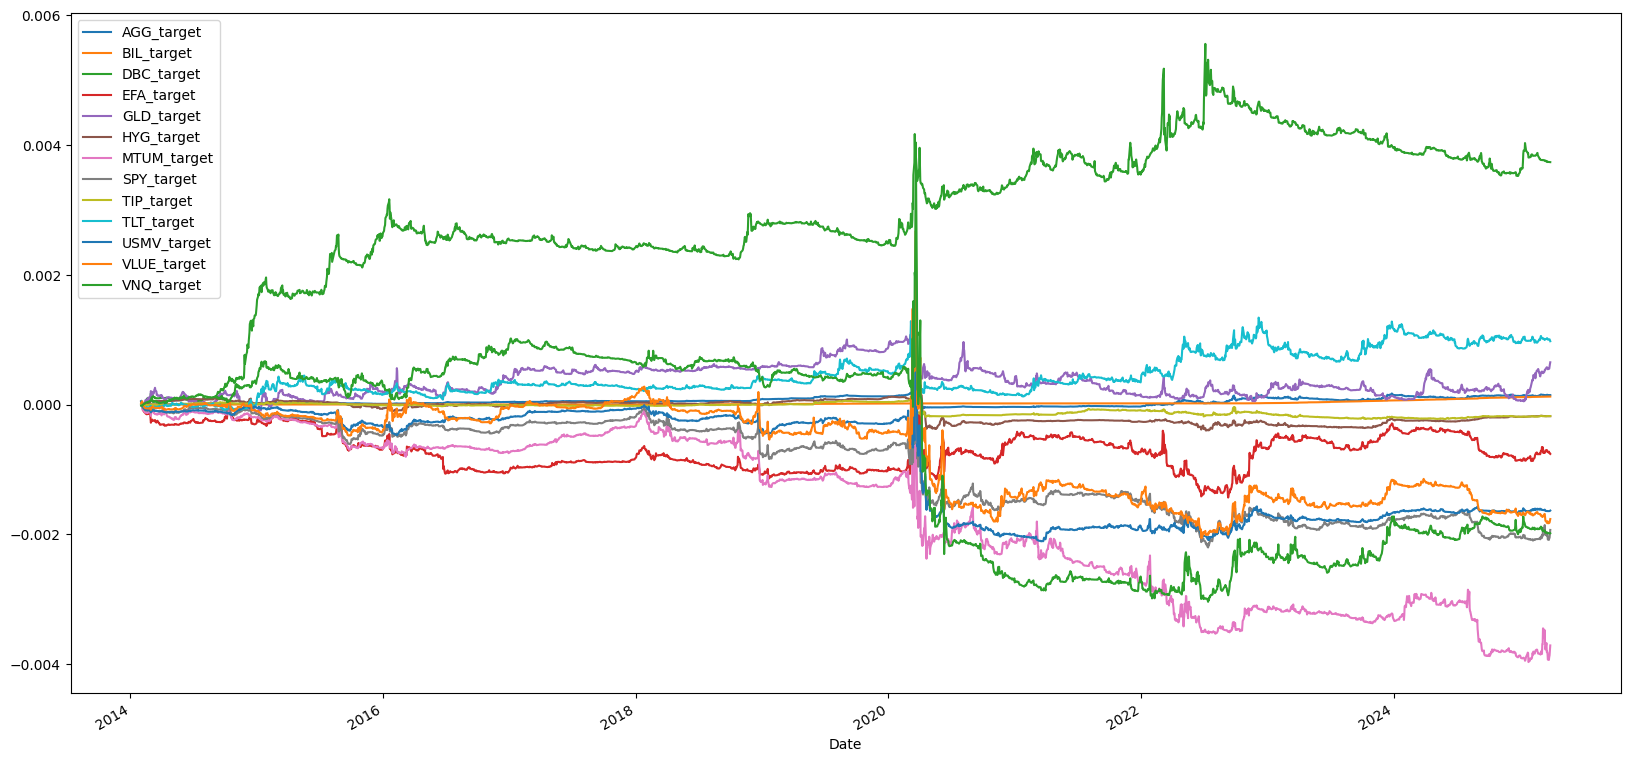

In [ ]:
(targets.rolling(250).sum().shift()*targets).cumsum().plot(figsize = (20,10))

In [149]:
technical_predictions = []
technical_rsqs = []
for col in targets.columns:
    features = generate_technical_features(targets[col])
    pred = an.rolling_model(targets[[col]],features,250*4,'linear')
    rsqs = an.rolling_model(targets[[col]],features,250*4,'linear',return_type = 'rsq')
    technical_predictions.append(pred)
    technical_rsqs.append(rsqs)

<Axes: xlabel='Date'>

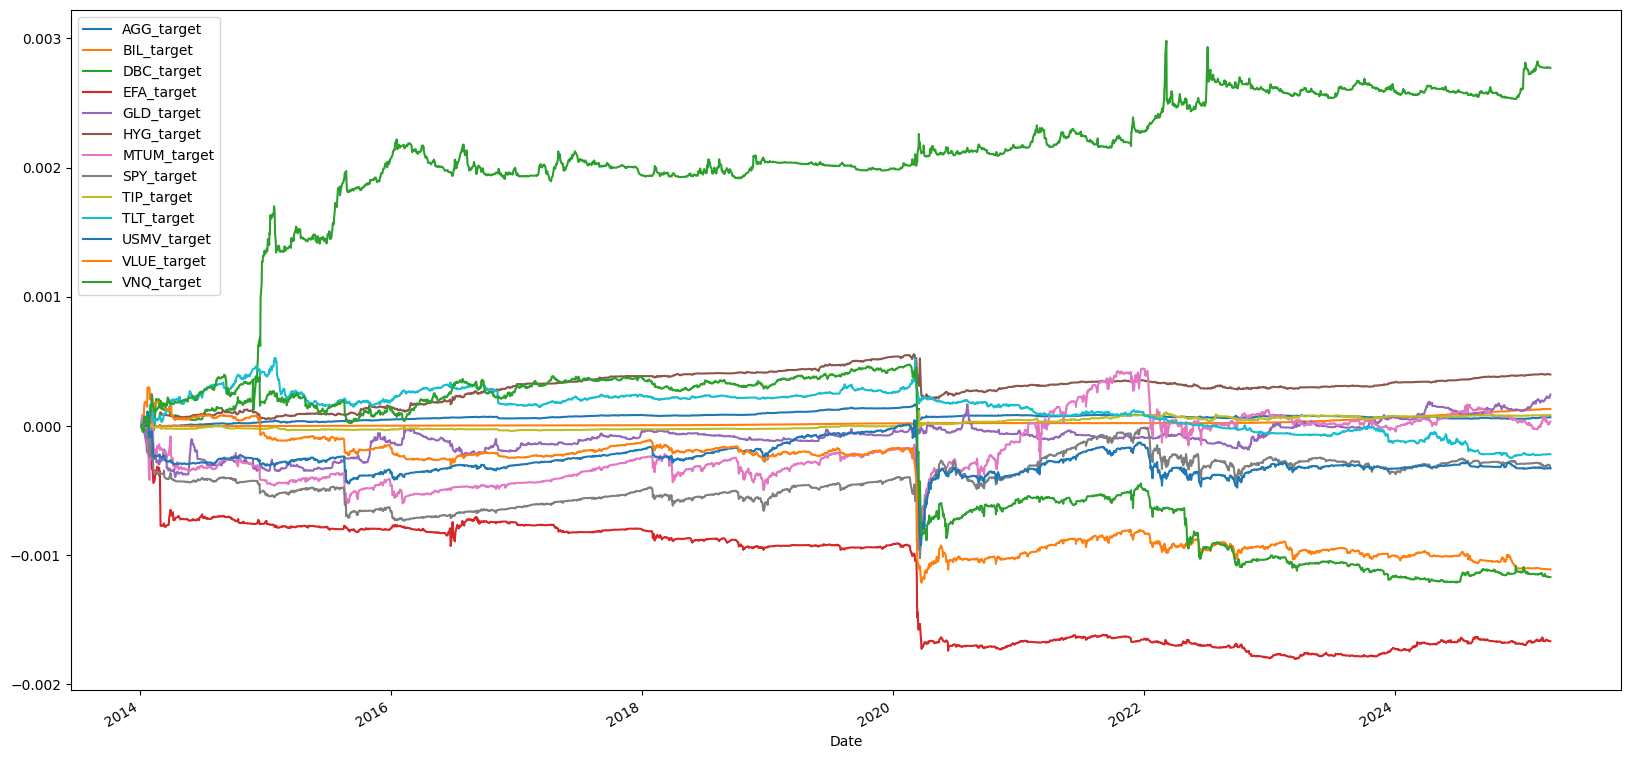

In [155]:
(pd.concat(technical_predictions,axis = 1)*targets).cumsum().plot(figsize = (20,10))

## Test out Factor Indicators

In [165]:
factors = merged[ff_factors.columns]
df = pd.concat([targets,factors],axis = 1).iloc[:250*2]
#sns.pairplot(df)
cmat = df.corr().iloc[13:,:13]
#sns.heatmap(abs(round(cmat,3)),cmap = 'viridis')
cmat

,AGG_target,BIL_target,DBC_target,EFA_target,GLD_target,HYG_target,MTUM_target,SPY_target,TIP_target,TLT_target,USMV_target,VLUE_target,VNQ_target
QMJ,0.060537,-0.098505,0.061666,-0.043464,0.070143,-0.062814,-0.087163,-0.085847,0.058767,0.072813,-0.088407,-0.046879,-0.040904
MKT-Rf,-0.088162,0.112662,0.009697,0.026264,-0.060212,0.048883,0.084206,0.083625,-0.037368,-0.050108,0.065314,0.128709,0.024524
SMB,0.007326,-0.007461,-0.092947,-0.032827,-0.011499,-0.018578,-0.025889,-0.022804,-0.025098,0.006463,-0.005719,-0.047194,0.022021
HML,0.051720,0.038023,0.017755,-0.044529,0.010674,0.039947,-0.055780,-0.040299,0.015336,0.004101,-0.035483,-0.050869,-0.036965
UMD,-0.044146,-0.033226,-0.031376,0.006969,0.008862,-0.015456,0.059982,0.039311,-0.024385,-0.004328,0.027872,0.038209,0.042732


<Axes: xlabel='Date'>

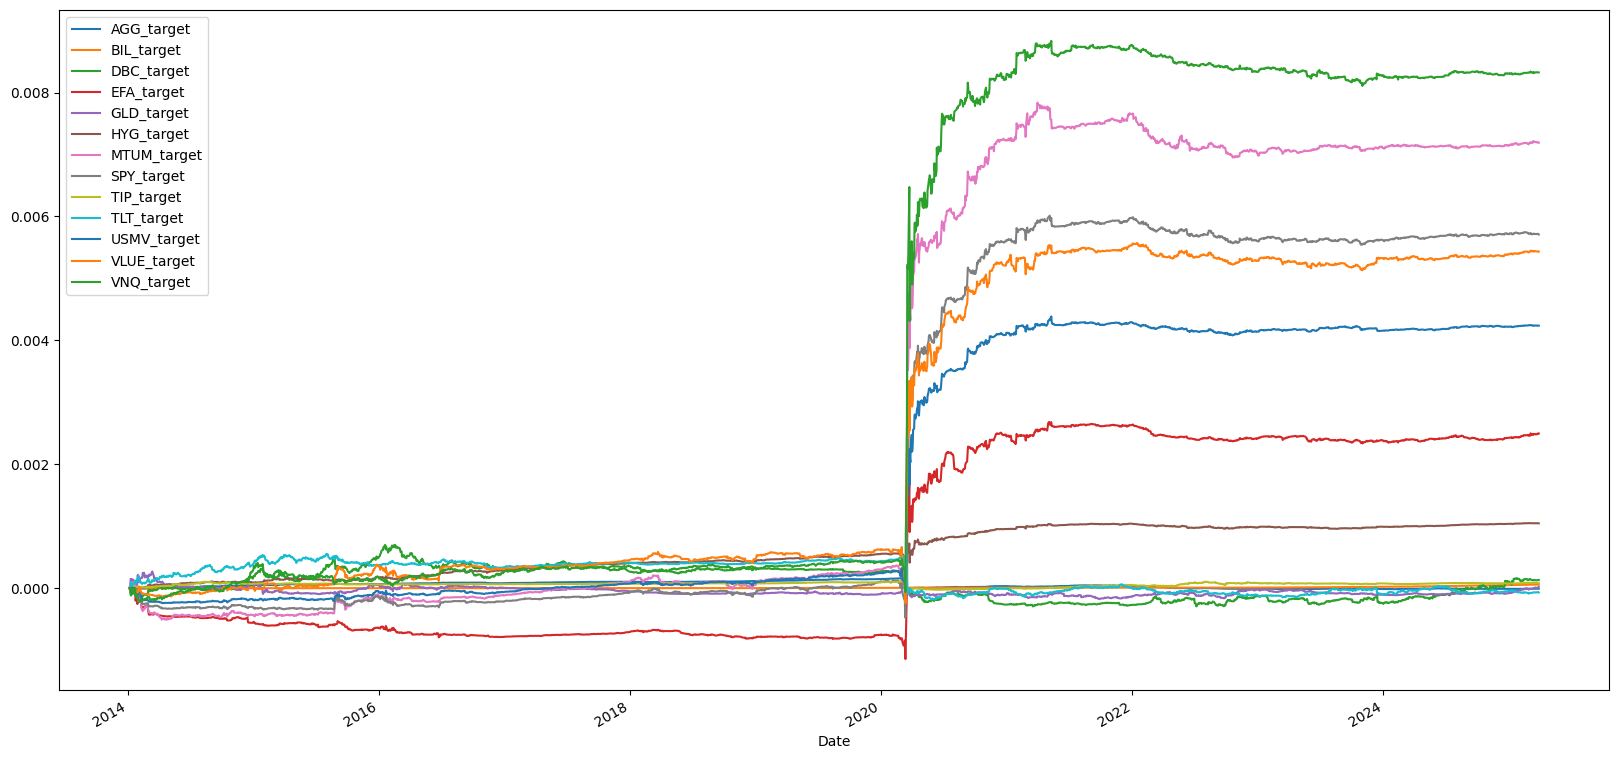

In [166]:
factor_predictions = []
factor_rsqs = []
for col in targets.columns:
    features =factors
    pred = an.rolling_model(targets[[col]],features,250*4,'linear')
    rsqs = an.rolling_model(targets[[col]],features,250*4,'linear',return_type = 'rsq')
    factor_predictions.append(pred)
    factor_rsqs.append(rsqs)
(pd.concat(factor_predictions,axis = 1)*targets).cumsum().plot(figsize = (20,10))

<Axes: xlabel='Date'>

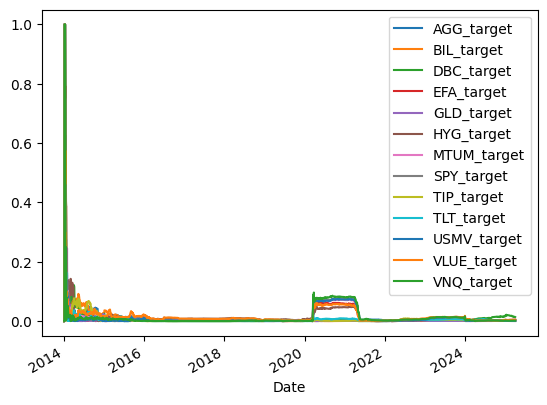

In [170]:
pd.concat(factor_rsqs,axis = 1).plot()

## Feature Engineering

In [23]:
merged['10Y_20Y'] = merged['10Y_Yield_Constant_Maturity'] - merged['20Y_Yield_Constant_Maturity']
merged.drop('20Y_Yield_Constant_Maturity',axis = 1,inplace = True)

## Feature Selection

Pick the features that have more than 0.02 correlation on absolute basis

In [416]:
temp

,AGG_target
Date,
2014-01-06,NaN
2014-01-07,0.000468
2014-01-08,-0.003003
2014-01-09,0.001409
2014-01-10,0.005054
...,...
2025-03-24,-0.003856
2025-03-25,0.000915
2025-03-26,-0.002441


In [457]:
technical_features[col].corr()

,ret_20d,skew_120d,zscore_250d
ret_20d,1.000000,0.205328,0.490379
skew_120d,0.205328,1.000000,0.204249
zscore_250d,0.490379,0.204249,1.000000


In [454]:
technical_features = {}
for col in targets.columns:
    temp = targets.shift(1)[col]
    tech = generate_technical_features(temp)
    #tech = an.extract_rolling_PCs(tech)
    #tech.columns = ['tech1','tech2']
    technical_features[col] = tech



In [225]:
macro_pc=an.extract_rolling_PCs(macro)
macro_pc.columns = ['macro1','macro2']

In [226]:
factors_pc = an.extract_rolling_PCs(factors)
factors_pc.columns = ['ff1','ff2']

In [227]:
pcs_full = pd.concat([factors_pc,macro_pc],axis = 1)
pcs_full

,ff1,ff2,macro1,macro2
Date,,,,
2014-01-06,0.000000,0.000000,0.000000,0.000000
2014-01-07,0.000000,0.000000,0.000000,0.000000
2014-01-08,-2.103534,-5.088121,0.000000,0.000000
2014-01-09,2.946139,-3.588357,0.000000,0.000000
2014-01-10,-0.977128,-0.940425,0.000000,0.000000
...,...,...,...,...
2025-03-24,-1.547591,0.644755,-0.783279,-2.352638
2025-03-25,2.347678,-0.923000,-0.783044,-2.358879
2025-03-26,0.915574,-2.538266,-0.782887,-2.364390


<Axes: xlabel='Date'>

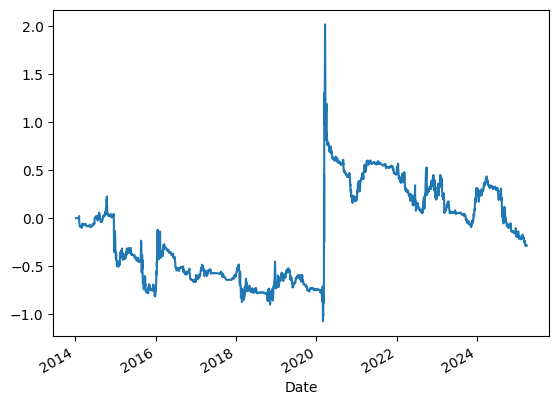

In [453]:
col = 'VLUE_target'
(technical_features[col].sum(axis=1) *targets[col]).cumsum().plot()

In [443]:

lookback_wdw = 250*5

def rolling_lr(fwd_rets,features,techincal_features,lookback_wdw):
    ret_df = []
    for col in fwd_rets.columns:
        ret_preds = [0]
        features_combined = pd.concat([features,technical_features[col]],axis = 1)
        features_combined = technical_features[col]
        for i in range(1,len(features)):
            tempY = fwd_rets.iloc[max(i-lookback_wdw,0):i][col]
            tempX = features_combined.iloc[max(i-lookback_wdw,0):i]
            testX = features_combined.iloc[[i]]
            testX = pd.DataFrame(testX)
            
            tempX = sm.add_constant(tempX)
            testX = pd.DataFrame([1]+testX.values[0].tolist()).T

            model = LinearRegression()
            model.fit(tempX,tempY)
            pred = model.predict(testX)
            ret_preds.append(pred[0])
        ret_pred = pd.DataFrame(ret_preds,index = fwd_rets.index,columns = [col])
        ret_df.append(ret_pred)
    return pd.concat(ret_df,axis = 1)

In [444]:
final_pred =rolling_lr(targets,pcs_full,technical_features,250*4)
final_pred

,AGG_target,BIL_target,DBC_target,EFA_target,GLD_target,HYG_target,MTUM_target,SPY_target,TIP_target,TLT_target,USMV_target,VLUE_target,VNQ_target
Date,,,,,,,,,,,,,
2014-01-06,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-01-07,0.000468,2.181409e-04,-0.000795,0.005599,-0.005707,0.000000,0.008218,0.006123,0.000181,0.002531,0.005689,0.005565,0.004434
2014-01-08,-0.001267,1.090704e-04,-0.005194,0.002648,-0.005808,-0.000322,0.007770,0.003171,-0.000226,-0.000097,0.002702,0.002782,-0.000230
2014-01-09,-0.000375,1.590163e-18,-0.006151,0.001514,-0.002914,0.000286,0.005788,0.002332,0.001114,0.001879,0.002274,0.001125,-0.000153
2014-01-10,0.000982,5.453522e-05,-0.002999,0.003429,0.001585,0.000964,0.004837,0.002428,0.002161,0.004372,0.002907,0.001643,0.003273
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,0.000153,3.556885e-04,-0.000235,-0.000177,0.000643,0.000301,0.000859,0.000587,0.000127,-0.000221,0.000450,0.000748,0.000381
2025-03-25,0.000087,3.586466e-04,-0.000314,-0.000152,0.000661,0.000303,0.000735,0.000568,0.000165,-0.000397,0.000441,0.000485,0.000396
2025-03-26,0.000084,3.601777e-04,-0.000361,-0.000227,0.000666,0.000293,0.000649,0.000498,0.000159,-0.000481,0.000405,0.000483,0.000393


<Axes: xlabel='Date'>

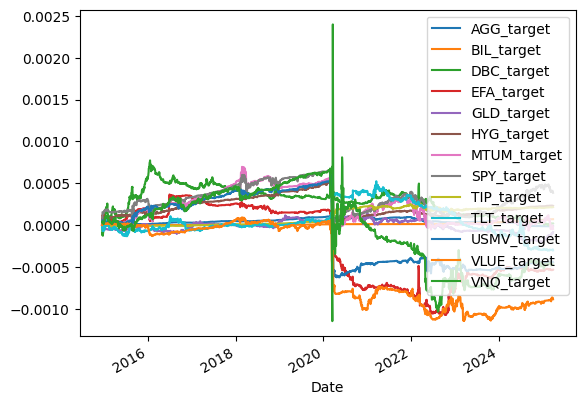

In [451]:
(targets*final_pred).iloc[250:].cumsum().plot()

In [426]:

def calculate_r2(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred)**2)      # Residual sum of squares
    ss_tot = np.sum((y_true - np.mean(y_true))**2)  # Total sum of squares
    return 1 - (ss_res / ss_tot)

In [427]:
calculate_r2(targets,final_pred)

AGG_target    -0.040365
BIL_target     0.103609
DBC_target    -0.003307
EFA_target    -0.036737
GLD_target    -0.034241
HYG_target    -0.024983
MTUM_target   -0.028738
SPY_target    -0.023846
TIP_target    -0.034435
TLT_target    -0.033434
USMV_target   -0.026669
VLUE_target   -0.027249
VNQ_target    -0.032982
dtype: float64

In [374]:
from xgboost import XGBRegressor

In [377]:


lookback_wdw = 250*5

def rolling_xgb(fwd_rets,features,lookback_wdw):
    ret_df = []
    for col in fwd_rets.columns:
        ret_preds = [0]
        for i in range(1,len(features)):
            tempY = fwd_rets.iloc[max(i-lookback_wdw,0):i][col]
            tempX = features.iloc[max(i-lookback_wdw,0):i]
            testX = features.iloc[[i]]
            testX = pd.DataFrame(testX)
            
            #tempX = sm.add_constant(tempX)
            #testX = pd.DataFrame([1]+testX.values[0].tolist()).T

            model = XGBRegressor()
            model.fit(tempX,tempY)
            pred = model.predict(testX)
            ret_preds.append(pred[0])
        ret_pred = pd.DataFrame(ret_preds,index = fwd_rets.index,columns = [col])
        ret_df.append(ret_pred)
    return pd.concat(ret_df,axis = 1)

In [384]:


def train_and_predict(col, fwd_rets, features, lookback_wdw):
    """Worker function for single column/series"""
    ret_preds = [0.0]  # Initialize first prediction
    for i in range(1, len(features)):
        # Prepare data
        tempY = fwd_rets.iloc[max(i-lookback_wdw, 0):i][col]
        tempX = features.iloc[max(i-lookback_wdw, 0):i]
        testX = features.iloc[[i]]
        
        # Train and predict
        model = XGBRegressor(
            n_estimators=100,
            tree_method='hist',  # Faster training
            n_jobs=1,           # Each thread gets its own model
            verbosity=0,         # Suppress logs
            max_depth = 6,
            learning_rate = 0.02,
            reg_alpha = 0.2

        )
        model.fit(tempX, tempY)
        pred = model.predict(testX)[0]
        ret_preds.append(pred)
    
    return pd.Series(ret_preds, index=fwd_rets.index, name=col)

def rolling_xgb_threaded(fwd_rets, features, lookback_wdw, max_workers=None):
    """
    Parallel rolling XGBoost using ThreadPoolExecutor
    
    Args:
        fwd_rets: DataFrame of forward returns (T x n_assets)
        features: DataFrame of features (T x n_features)
        lookback_wdw: Lookback window size
        max_workers: Number of threads (None for auto)
    
    Returns:
        DataFrame of predictions (same shape as fwd_rets)
    """
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        futures = [
            executor.submit(
                train_and_predict,
                col, fwd_rets, features, lookback_wdw
            )
            for col in fwd_rets.columns
        ]
        
        # Collect results with progress bar
        results = []
        for future in tqdm(futures, desc="Processing assets"):
            results.append(future.result())
    
    return pd.concat(results, axis=1)

In [ ]:
final_pred =rolling_xgb_threaded(targets,pcs_full,250*5)
final_pred

Processing assets: 100%|██████████| 13/13 [11:17<00:00, 52.15s/it]  


,AGG_target,BIL_target,DBC_target,EFA_target,GLD_target,HYG_target,MTUM_target,SPY_target,TIP_target,TLT_target,USMV_target,VLUE_target,VNQ_target
Date,,,,,,,,,,,,,
2014-01-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-01-07,0.000468,0.000218,-0.000795,0.005599,-0.005707,0.000000,0.008218,0.006123,0.000181,0.002531,0.005689,0.005565,0.004434
2014-01-08,-0.001267,0.000109,-0.005194,0.002648,-0.005808,-0.000322,0.007770,0.003171,-0.000226,-0.000097,0.002702,0.002782,-0.000230
2014-01-09,-0.000375,0.000000,-0.006151,0.001514,-0.002914,0.000286,0.005788,0.002332,0.001114,0.001879,0.002274,0.001125,-0.000153
2014-01-10,0.000982,0.000055,-0.002999,0.003429,0.001585,0.000964,0.004837,0.002428,0.002161,0.004372,0.002907,0.001643,0.003273
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,0.000218,0.000469,0.000301,0.000386,0.000981,0.000607,0.000684,0.000630,0.000195,-0.000040,0.000534,0.000441,0.000652
2025-03-25,0.000222,0.000468,-0.000088,0.000478,0.000976,0.000612,0.001216,0.000700,0.000199,-0.000020,0.000540,0.000465,0.000387
2025-03-26,0.000224,0.000468,0.000125,0.000346,0.001006,0.000593,0.000633,0.000589,0.000201,-0.000036,0.000524,0.000419,0.000035


<Axes: xlabel='Date'>

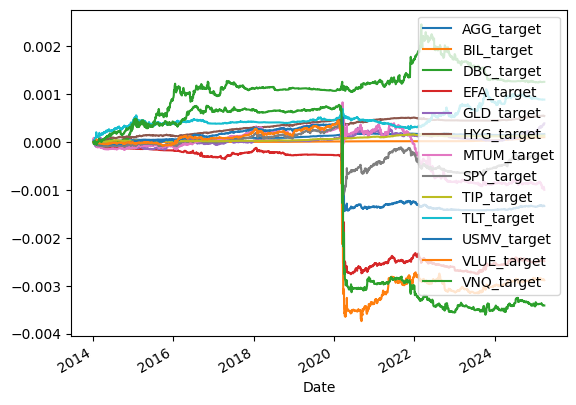

In [390]:
(targets*final_pred).cumsum().plot()

<Axes: xlabel='Date'>

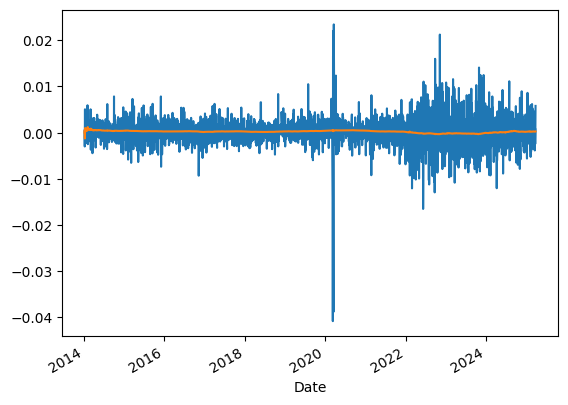

In [392]:
col = 'AGG_target'
targets[col].plot()
final_pred[col].plot()

In [393]:


def train_rf_series(col, fwd_rets, features, lookback_wdw, rf_params):
    """Train/predict for a single return series"""
    preds = np.zeros(len(features))
    preds[0] = 0.0  # Initialize first prediction
    
    for i in range(1, len(features)):
        # Prepare rolling window
        train_idx = slice(max(i-lookback_wdw, 0), i)
        tempY = fwd_rets.iloc[train_idx][col]
        tempX = features.iloc[train_idx]
        testX = features.iloc[[i]]
        
        # Initialize model with thread-safe config
        model = RandomForestRegressor(
            **rf_params,
            n_jobs=1,  # Critical for thread safety
            verbose=0
        )
        model.fit(tempX, tempY)
        preds[i] = model.predict(testX)[0]
    
    return pd.Series(preds, index=fwd_rets.index, name=col)

def threaded_rolling_rf(fwd_rets, features, lookback_wdw, 
                       rf_params=None, max_workers=None):
    """
    Threaded rolling window Random Forest predictor
    
    Parameters:
    - fwd_rets: DataFrame of forward returns (T x n_assets)
    - features: DataFrame of features (T x n_features)
    - lookback_wdw: Training window size
    - rf_params: Dict of RandomForest parameters
    - max_workers: Thread count (None for auto)
    
    Returns:
    DataFrame of predictions (same shape as fwd_rets)
    """
    # Default RF parameters optimized for finance
    default_params = {
        'n_estimators': 100,
        'max_depth': 6,
        'min_samples_split': 20,  # Higher for noisy financial data
        'max_features': 0.3,      # Conservative for alpha signals
        'random_state': 42
    }
    rf_params = rf_params or default_params
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        futures = [
            executor.submit(
                train_rf_series,
                col, fwd_rets, features, lookback_wdw, rf_params
            )
            for col in fwd_rets.columns
        ]
        
        # Collect results with progress bar
        results = []
        for future in tqdm(futures, desc='Training assets', unit='asset'):
            results.append(future.result())
    
    return pd.concat(results, axis=1)


In [394]:
final_pred = threaded_rolling_rf(targets,features,250*5,)

Training assets: 100%|██████████| 13/13 [1:06:56<00:00, 308.98s/asset]   


<Axes: xlabel='Date'>

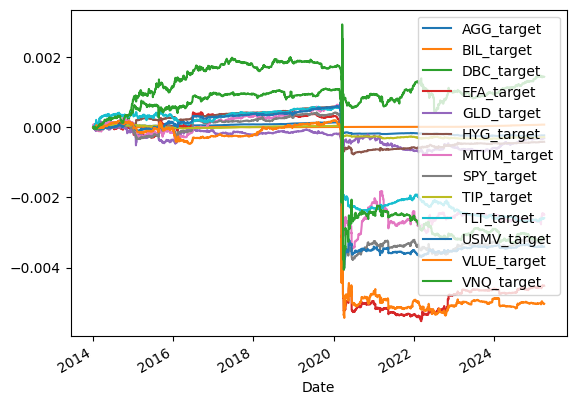

In [395]:
(targets*final_pred).cumsum().plot()

# MK Attempt  Linear Model

## Random Forest Model

In [43]:
merged[['MKT-Rf','QMJ','SMB','HML',"UMD",'10 Year']].shape[1]

6

In [65]:
prediction_linear = an.rolling_model(targets,merged[['MKT-Rf','QMJ','SMB','HML',"UMD",'10 Year']],250*2,model ='linear',perform_PCA=False)

In [64]:
pred_rsq = an.rolling_model(targets,merged[['MKT-Rf','QMJ','SMB','HML',"UMD",'10 Year']],250*2,model ='linear',perform_PCA=True,return_type = 'rsq')

In [66]:
pred_rsq

,AGG_target,BIL_target,DBC_target,EFA_target,GLD_target,HYG_target,MTUM_target,SPY_target,TIP_target,TLT_target,USMV_target,VLUE_target,VNQ_target
Date,,,,,,,,,,,,,
2014-01-06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2014-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000
2014-01-09,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000
2014-01-10,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,0.016149,0.024636,0.018987,0.019334,0.013270,0.017281,0.005116,0.005550,0.018404,0.012810,0.010762,0.019751,0.014308
2025-03-25,0.015956,0.024733,0.018968,0.019595,0.014189,0.016479,0.004914,0.005775,0.018516,0.012108,0.010162,0.020262,0.014025
2025-03-26,0.015292,0.024803,0.020000,0.021634,0.012987,0.017306,0.005274,0.005042,0.017884,0.011915,0.011061,0.021403,0.014526


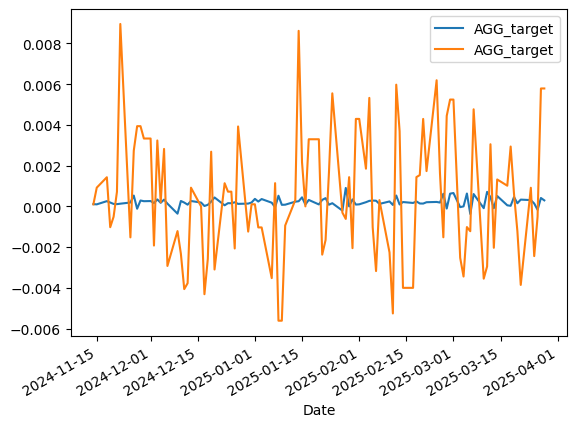

In [61]:
stock = 'AGG_target'
prediction_linear[stock].iloc[-100:].plot()
targets[stock].iloc[-100:].plot()
plt.legend()

In [57]:
prediction_enet = an.rolling_model(targets,merged[['MKT-Rf','QMJ','SMB','HML',"UMD"]],250*2,model ='eNet',perform_PCA=False)

In [193]:
prediction_linear.to_excel("pred_linear.xlsx")
prediction_enet.to_excel("pred_enet.xlsx")

prediction_xgb = an.rolling_model(targets,merged,250*5,model = 'XGB')

prediction_rf =  an.rolling_model(targets,merged,250*5,model = 'RF')

<Axes: xlabel='Date'>

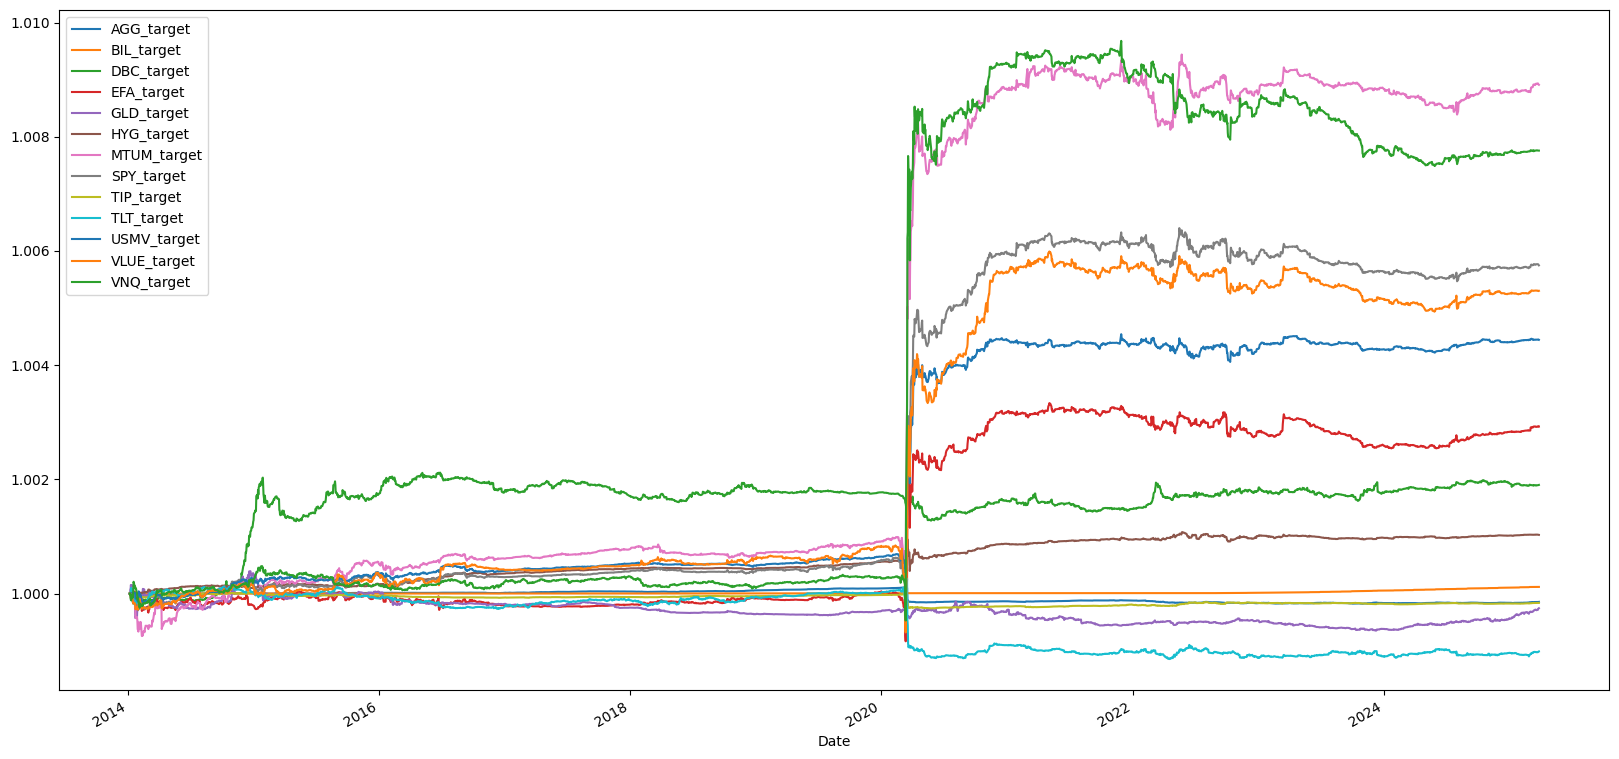

In [53]:

((1+prediction_linear*targets)).cumprod().plot(figsize = (20,10))#.plot(figsize = (10,8))


<Axes: xlabel='Date'>

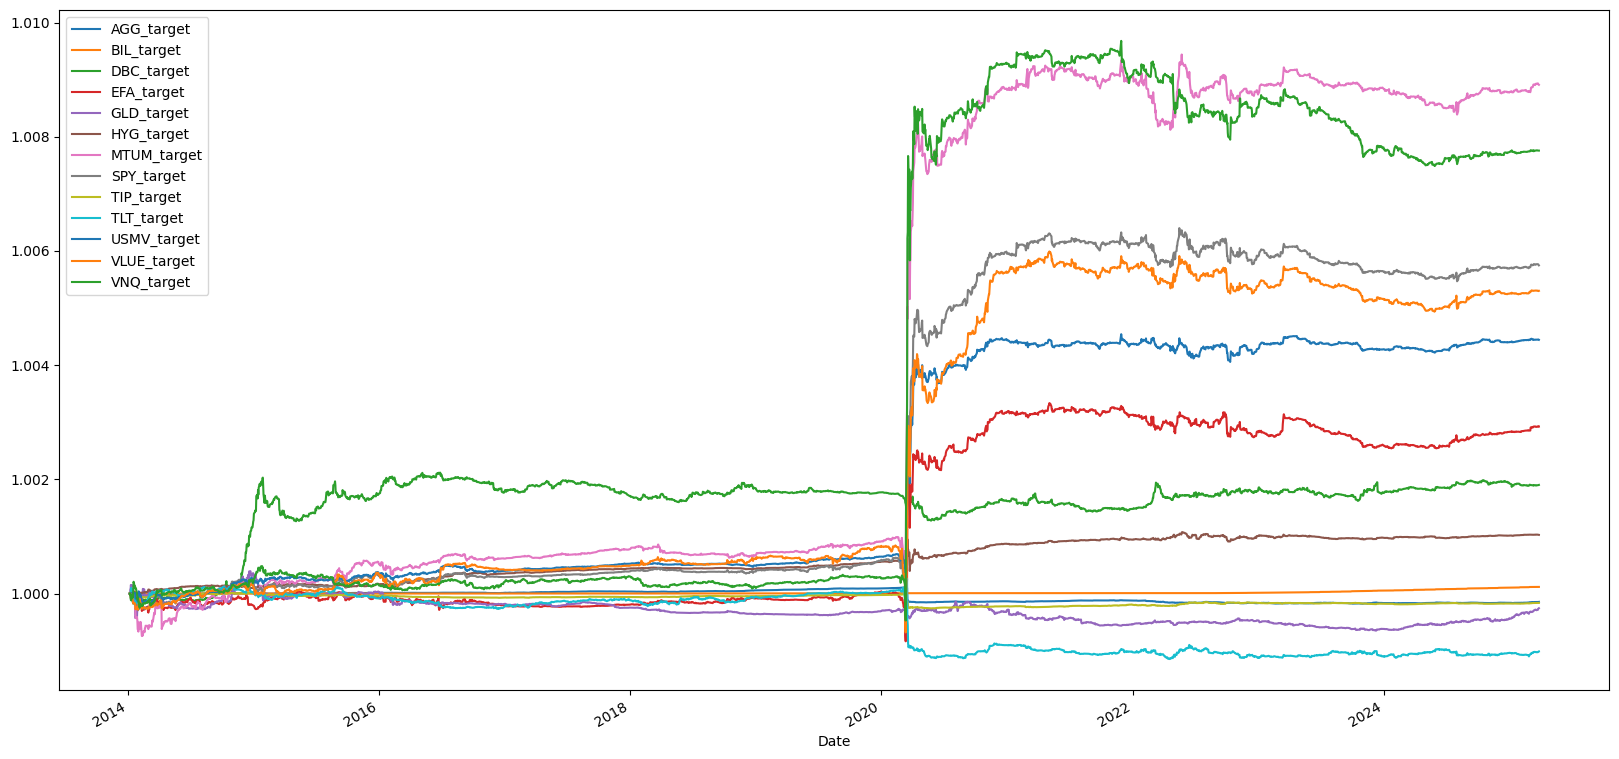

In [ ]:

((1+prediction_linear*targets)).cumprod().plot(figsize = (20,10))#.plot(figsize = (10,8))


In [47]:

((1+prediction_enet*targets)).cumprod().plot(figsize = (20,10))#.plot(figsize = (10,8))

NameError: name 'prediction_enet' is not defined

# Notes Below

# Engineer Returns

## Feature Engineering

In [5]:
from src.feature_engineering import generate_all_features

equity_X, fixed_income_X, commodity_X, targets = generate_all_features(merged, returns, targets)

# Save the processed data
equity_X.to_csv("data/processed/equity_X.csv")
fixed_income_X.to_csv("data/processed/fixed_income_X.csv")
commodity_X.to_csv("data/processed/commodity_X.csv")
targets.to_csv("data/processed/aligned_etf_target_returns.csv")


✅ Equity features shape: (2587, 48)
✅ Fixed income features shape: (2720, 6)
✅ Commodity features shape: (2587, 7)
🔍 NaN in equity features? False
🔍 NaN in fixed income features? False
🔍 NaN in commodity features? False

🧠 Equity feature columns:
 ['MKT-Rf', 'SMB', 'HML', 'UMD', 'QMJ', 'VIX', 'VVIX', 'Consumer_Confidence_Index', 'Unemployment_Initial_Claims', 'AGG_ret_lag1', 'BIL_ret_lag1', 'DBC_ret_lag1', 'EFA_ret_lag1', 'GLD_ret_lag1', 'HYG_ret_lag1', 'MTUM_ret_lag1', 'SPY_ret_lag1', 'TIP_ret_lag1', 'TLT_ret_lag1', 'USMV_ret_lag1', 'VLUE_ret_lag1', 'VNQ_ret_lag1', 'AGG_ret_lag5', 'BIL_ret_lag5', 'DBC_ret_lag5', 'EFA_ret_lag5', 'GLD_ret_lag5', 'HYG_ret_lag5', 'MTUM_ret_lag5', 'SPY_ret_lag5', 'TIP_ret_lag5', 'TLT_ret_lag5', 'USMV_ret_lag5', 'VLUE_ret_lag5', 'VNQ_ret_lag5', 'AGG_ret_lag20', 'BIL_ret_lag20', 'DBC_ret_lag20', 'EFA_ret_lag20', 'GLD_ret_lag20', 'HYG_ret_lag20', 'MTUM_ret_lag20', 'SPY_ret_lag20', 'TIP_ret_lag20', 'TLT_ret_lag20', 'USMV_ret_lag20', 'VLUE_ret_lag20', 'VNQ_ret_

In [6]:
equity_X

,MKT-Rf,SMB,HML,UMD,QMJ,VIX,VVIX,Consumer_Confidence_Index,Unemployment_Initial_Claims,AGG_ret_lag1,...,EFA_ret_lag20,GLD_ret_lag20,HYG_ret_lag20,MTUM_ret_lag20,SPY_ret_lag20,TIP_ret_lag20,TLT_ret_lag20,USMV_ret_lag20,VLUE_ret_lag20,VNQ_ret_lag20
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-16,0.109240,-0.447279,1.486029,-1.070982,-1.029148,3.768653,3.755584,1.223809,-1.735744,-1.755606,...,-0.519940,-0.368940,-0.101333,0.131870,0.006273,-1.288067,-0.489362,0.395813,-0.377047,0.527462
2014-12-17,1.830391,1.008532,1.573472,-1.616838,-2.959786,2.069126,2.310075,1.214357,-1.719445,1.314201,...,1.443946,0.998904,-0.816290,1.293560,0.766971,0.288476,0.328462,0.751141,-0.089275,0.505894
2014-12-18,3.340178,-3.162724,-0.425705,-0.310271,-0.155155,1.043345,1.770611,1.205018,-1.703484,-0.881786,...,-0.390366,-1.291545,-0.142525,-0.562787,-0.329106,-1.570729,-1.082298,-0.192580,0.971643,-1.409382
2014-12-19,1.112980,-0.590526,0.992073,-1.325405,-2.482056,0.914864,1.181579,1.195791,-1.685911,-1.678373,...,-0.785976,1.168672,-0.015962,-0.160621,0.167971,0.902745,0.708064,-0.059855,0.100039,0.358478
2014-12-22,0.608372,-0.802515,-1.001545,0.409691,1.720680,0.438471,1.208786,1.186672,-1.023318,0.834875,...,1.141309,0.530670,2.052067,0.542292,0.696143,1.057178,0.830955,0.338170,0.907506,0.769898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-25,0.158051,-1.132151,0.469010,0.964026,1.055830,0.126917,-0.680002,-1.836171,-0.556597,-1.230240,...,1.063786,-1.527804,0.798998,-0.383912,-0.716133,1.458758,1.963228,0.945765,-0.304505,1.174420
2025-03-26,-1.260886,-0.377036,2.230879,-1.600194,2.119527,0.446879,-0.494781,-1.825386,-0.560182,0.224401,...,0.119133,0.010284,0.382700,0.457746,-0.021617,0.213268,0.661370,-1.447828,-0.226096,-0.471536
2025-03-27,-0.484543,0.455525,0.207952,-0.576311,0.808908,0.545711,-0.537623,-1.814742,-0.566563,-0.791896,...,-1.441686,-1.728673,-0.835345,-1.519337,-2.106666,-0.515487,-0.823715,-0.239090,-1.180690,0.346765


## Preprocessing & Fitting xgboost



In [10]:
import sys
import os
import pandas as pd

# Add src folder to path
sys.path.append(os.path.abspath("src"))

# Import the correct function
from prepare_xgboost_data import prepare_xgboost_data

# Set file paths
equity_X_path = "data/processed/equity_X.csv"
targets_path = "data/processed/aligned_etf_target_returns.csv"
equity_etfs = ["SPY", "MTUM", "VLUE", "USMV", "EFA"]

# Run panel preparation
panel_df = prepare_xgboost_data(equity_X_path, targets_path, equity_etfs)
if "index" in panel_df.columns:
    panel_df = panel_df.drop(columns=["index"])

# Save to disk
output_path = "data/processed/xgboost_equity_panel.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
panel_df.to_csv(output_path,index=False)
print(f"\n✅ Saved XGBoost-ready panel to: {output_path}")

# Load and inspect
df = pd.read_csv(output_path, parse_dates=["Date"])
print("✅ Loaded panel shape:", df.shape)
print("✅ Columns:", df.columns.tolist())
print("\n=== Head ===")
print(df.head())

# Missing value check
missing = df.isnull().sum()
print("\n=== Missing values ===")
print(missing[missing > 0])

# Assert presence of expected ETFs
expected_etfs = set(equity_etfs)
actual_etfs = set(df["ETF"].unique())
assert expected_etfs.issubset(actual_etfs), "❌ Missing some expected ETFs!"
print("\n✅ All expected ETFs are present.")


=== Loading CSVs ===
✅ equity_X shape: (2587, 48)
✅ targets shape: (2587, 13)
✅ equity_X preview:
              MKT-Rf       SMB       HML       UMD       QMJ       VIX  \
Date                                                                     
2014-12-16  0.109240 -0.447279  1.486029 -1.070982 -1.029148  3.768653   
2014-12-17  1.830391  1.008532  1.573472 -1.616838 -2.959786  2.069126   
2014-12-18  3.340178 -3.162724 -0.425705 -0.310271 -0.155155  1.043345   
2014-12-19  1.112980 -0.590526  0.992073 -1.325405 -2.482056  0.914864   
2014-12-22  0.608372 -0.802515 -1.001545  0.409691  1.720680  0.438471   

                VVIX  Consumer_Confidence_Index  Unemployment_Initial_Claims  \
Date                                                                           
2014-12-16  3.755584                   1.223809                    -1.735744   
2014-12-17  2.310075                   1.214357                    -1.719445   
2014-12-18  1.770611                   1.205018                

In [11]:
# === Step 1: Set up path and imports ===
import os
import sys
import pandas as pd

# Add src/ to the import path
sys.path.append(os.path.abspath("src"))

from models.xgboost_trainer import train_xgboost_regressor

# === Step 2: Define the path to panel data ===
panel_path = "data/processed/xgboost_equity_panel.csv"
assert os.path.exists(panel_path), "❌ Panel CSV not found"

# === Step 3: Load the panel CSV ===
panel_df = pd.read_csv(panel_path, parse_dates=["Date"])
print(f"✅ Loaded panel with shape: {panel_df.shape}")
print("✅ Columns:", panel_df.columns.tolist())
print("\n=== Sample ===")
print(panel_df.head())

# === Step 4: Run the training function ===
train_xgboost_regressor(panel_df)

# The function will:
# - Train one XGBoost model per ETF
# - Print metrics (R², MSE)
# - Plot in-sample vs out-of-sample predicted vs actual
# - Save plots under reports/figures/


[I 2025-06-09 12:02:07,955] A new study created in memory with name: no-name-592148bb-8f41-4201-9d1c-4c29e24d1b48


✅ Loaded panel with shape: (12935, 27)
✅ Columns: ['Date', 'ETF', 'MKT-Rf', 'SMB', 'HML', 'UMD', 'QMJ', 'VIX', 'VVIX', 'Consumer_Confidence_Index', 'Unemployment_Initial_Claims', 'EFA_ret_lag1', 'MTUM_ret_lag1', 'SPY_ret_lag1', 'USMV_ret_lag1', 'VLUE_ret_lag1', 'EFA_ret_lag5', 'MTUM_ret_lag5', 'SPY_ret_lag5', 'USMV_ret_lag5', 'VLUE_ret_lag5', 'EFA_ret_lag20', 'MTUM_ret_lag20', 'SPY_ret_lag20', 'USMV_ret_lag20', 'VLUE_ret_lag20', 'target']

=== Sample ===
        Date  ETF    MKT-Rf       SMB       HML       UMD       QMJ       VIX  \
0 2014-12-16  SPY  0.109240 -0.447279  1.486029 -1.070982 -1.029148  3.768653   
1 2014-12-17  SPY  1.830391  1.008532  1.573472 -1.616838 -2.959786  2.069126   
2 2014-12-18  SPY  3.340178 -3.162724 -0.425705 -0.310271 -0.155155  1.043345   
3 2014-12-19  SPY  1.112980 -0.590526  0.992073 -1.325405 -2.482056  0.914864   
4 2014-12-22  SPY  0.608372 -0.802515 -1.001545  0.409691  1.720680  0.438471   

       VVIX  Consumer_Confidence_Index  ...  MTUM_ret_

[I 2025-06-09 12:02:08,315] Trial 0 finished with value: 8.25889155117934e-05 and parameters: {'learning_rate': 0.2054209391365116, 'max_depth': 4, 'min_child_weight': 7, 'subsample': 0.8743600138350753, 'colsample_bytree': 0.5501742182818226, 'n_estimators': 171, 'reg_alpha': 0.2989076884198627, 'reg_lambda': 0.38173455270832646}. Best is trial 0 with value: 8.25889155117934e-05.
[I 2025-06-09 12:02:08,513] Trial 1 finished with value: 8.465325485272388e-05 and parameters: {'learning_rate': 0.29198330751859297, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.5518837585928196, 'colsample_bytree': 0.6754967889422681, 'n_estimators': 92, 'reg_alpha': 0.2750171223331259, 'reg_lambda': 0.41679562456438846}. Best is trial 0 with value: 8.25889155117934e-05.
[I 2025-06-09 12:02:08,685] Trial 2 finished with value: 7.42700143879178e-05 and parameters: {'learning_rate': 0.17663286631605712, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.6622615545370629, 'colsample_bytree': 0.9851

✅ Best hyperparameters: {'learning_rate': 0.12440337076999555, 'max_depth': 8, 'min_child_weight': 10, 'subsample': 0.6838913712916166, 'colsample_bytree': 0.6192512209920994, 'n_estimators': 113, 'reg_alpha': 0.8838828033954315, 'reg_lambda': 0.4988054977452255, 'random_state': 42, 'n_jobs': -1}
Train R²: 0.0032, MSE: 0.000130
Test  R²: 0.0003, MSE: 0.000071


[I 2025-06-09 12:02:15,765] A new study created in memory with name: no-name-793a82a1-e21a-41c1-9053-fdac0655f401



=== Training model for ETF: MTUM ===
Train shape: (2275, 12), Test shape: (312, 12)
📌 Feature columns: ['Consumer_Confidence_Index', 'HML', 'MKT-Rf', 'MTUM_ret_lag1', 'MTUM_ret_lag20', 'MTUM_ret_lag5', 'QMJ', 'SMB', 'UMD', 'Unemployment_Initial_Claims', 'VIX', 'VVIX']
📅 Train date range: 2014-12-16 to 2023-12-29
📅 Test date range: 2024-01-02 to 2025-03-31


[I 2025-06-09 12:02:16,078] Trial 0 finished with value: 0.00016428788498019838 and parameters: {'learning_rate': 0.22578815770208563, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.6904568020237192, 'colsample_bytree': 0.549354508424438, 'n_estimators': 272, 'reg_alpha': 0.6285631353497817, 'reg_lambda': 0.49376776169638836}. Best is trial 0 with value: 0.00016428788498019838.
[I 2025-06-09 12:02:16,302] Trial 1 finished with value: 0.00016514793024765875 and parameters: {'learning_rate': 0.2724771909066396, 'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.7515512455808999, 'colsample_bytree': 0.7243763374784953, 'n_estimators': 306, 'reg_alpha': 0.5994820260633483, 'reg_lambda': 0.7326735765845368}. Best is trial 0 with value: 0.00016428788498019838.
[I 2025-06-09 12:02:16,597] Trial 2 finished with value: 0.00016241153638533247 and parameters: {'learning_rate': 0.07801630972292899, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.9065394543403464, 'colsample_bytree

✅ Best hyperparameters: {'learning_rate': 0.11758155661946332, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.6415541085357558, 'colsample_bytree': 0.6608601996591872, 'n_estimators': 194, 'reg_alpha': 0.8116929528575485, 'reg_lambda': 0.3045800106658087, 'random_state': 42, 'n_jobs': -1}
Train R²: 0.0214, MSE: 0.000158
Test  R²: -0.0013, MSE: 0.000160


[I 2025-06-09 12:02:24,136] A new study created in memory with name: no-name-7036440f-5ab5-4190-9358-c2945379082b



=== Training model for ETF: VLUE ===
Train shape: (2275, 12), Test shape: (312, 12)
📌 Feature columns: ['Consumer_Confidence_Index', 'HML', 'MKT-Rf', 'QMJ', 'SMB', 'UMD', 'Unemployment_Initial_Claims', 'VIX', 'VLUE_ret_lag1', 'VLUE_ret_lag20', 'VLUE_ret_lag5', 'VVIX']
📅 Train date range: 2014-12-16 to 2023-12-29
📅 Test date range: 2024-01-02 to 2025-03-31


[I 2025-06-09 12:02:24,330] Trial 0 finished with value: 7.44940891406616e-05 and parameters: {'learning_rate': 0.17993029351574588, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.6451234866099715, 'colsample_bytree': 0.8744410935761948, 'n_estimators': 95, 'reg_alpha': 0.5303366525069622, 'reg_lambda': 0.2847731201583765}. Best is trial 0 with value: 7.44940891406616e-05.
[I 2025-06-09 12:02:25,364] Trial 1 finished with value: 0.00010334847157605871 and parameters: {'learning_rate': 0.07503791455576418, 'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.5116132441830793, 'colsample_bytree': 0.7151907714728397, 'n_estimators': 476, 'reg_alpha': 0.03499438875978367, 'reg_lambda': 0.5733624372030353}. Best is trial 0 with value: 7.44940891406616e-05.
[I 2025-06-09 12:02:25,592] Trial 2 finished with value: 7.166887644881198e-05 and parameters: {'learning_rate': 0.13242768095600302, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.5341300852446802, 'colsample_bytree': 0.

✅ Best hyperparameters: {'learning_rate': 0.2130896583696495, 'max_depth': 8, 'min_child_weight': 10, 'subsample': 0.6570167452311975, 'colsample_bytree': 0.8618508185539492, 'n_estimators': 156, 'reg_alpha': 0.9966240119348129, 'reg_lambda': 0.4947653529546675, 'random_state': 42, 'n_jobs': -1}
Train R²: 0.0056, MSE: 0.000159
Test  R²: 0.0042, MSE: 0.000072


[I 2025-06-09 12:02:33,302] A new study created in memory with name: no-name-5b3603af-cfdc-491f-8848-8812868258ea



=== Training model for ETF: USMV ===
Train shape: (2275, 12), Test shape: (312, 12)
📌 Feature columns: ['Consumer_Confidence_Index', 'HML', 'MKT-Rf', 'QMJ', 'SMB', 'UMD', 'USMV_ret_lag1', 'USMV_ret_lag20', 'USMV_ret_lag5', 'Unemployment_Initial_Claims', 'VIX', 'VVIX']
📅 Train date range: 2014-12-16 to 2023-12-29
📅 Test date range: 2024-01-02 to 2025-03-31


[I 2025-06-09 12:02:33,527] Trial 0 finished with value: 5.500799056995518e-05 and parameters: {'learning_rate': 0.20030698849259104, 'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.7033384066605617, 'colsample_bytree': 0.9652836989904894, 'n_estimators': 60, 'reg_alpha': 0.014292100113131201, 'reg_lambda': 0.1408372934853388}. Best is trial 0 with value: 5.500799056995518e-05.
[I 2025-06-09 12:02:33,853] Trial 1 finished with value: 4.065171461594344e-05 and parameters: {'learning_rate': 0.17744230003141395, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.6896196891491508, 'colsample_bytree': 0.5329848783730954, 'n_estimators': 288, 'reg_alpha': 0.2779854781788197, 'reg_lambda': 0.7216954923960031}. Best is trial 1 with value: 4.065171461594344e-05.
[I 2025-06-09 12:02:34,071] Trial 2 finished with value: 3.310787497437074e-05 and parameters: {'learning_rate': 0.07716678396971575, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.8671528648269646, 'colsample_bytree': 0

✅ Best hyperparameters: {'learning_rate': 0.24952394366695085, 'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.9750736505769617, 'colsample_bytree': 0.7788030712456234, 'n_estimators': 239, 'reg_alpha': 0.628364935956312, 'reg_lambda': 0.1902195405817757, 'random_state': 42, 'n_jobs': -1}
Train R²: 0.0096, MSE: 0.000091
Test  R²: 0.0070, MSE: 0.000032


[I 2025-06-09 12:02:40,948] A new study created in memory with name: no-name-c573ae17-3979-4d5a-97cf-9c8530dc405f



=== Training model for ETF: EFA ===
Train shape: (2275, 12), Test shape: (312, 12)
📌 Feature columns: ['Consumer_Confidence_Index', 'EFA_ret_lag1', 'EFA_ret_lag20', 'EFA_ret_lag5', 'HML', 'MKT-Rf', 'QMJ', 'SMB', 'UMD', 'Unemployment_Initial_Claims', 'VIX', 'VVIX']
📅 Train date range: 2014-12-16 to 2023-12-29
📅 Test date range: 2024-01-02 to 2025-03-31


[I 2025-06-09 12:02:41,393] Trial 0 finished with value: 8.370645432603952e-05 and parameters: {'learning_rate': 0.2244461759773848, 'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.9369351399921989, 'colsample_bytree': 0.9344765999604537, 'n_estimators': 385, 'reg_alpha': 0.1875364126435295, 'reg_lambda': 0.23935493534098184}. Best is trial 0 with value: 8.370645432603952e-05.
[I 2025-06-09 12:02:41,828] Trial 1 finished with value: 7.758603482048096e-05 and parameters: {'learning_rate': 0.12491410652732508, 'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.8748911566433967, 'colsample_bytree': 0.7377997763620526, 'n_estimators': 377, 'reg_alpha': 0.26579472585776953, 'reg_lambda': 0.4696177892010954}. Best is trial 1 with value: 7.758603482048096e-05.
[I 2025-06-09 12:02:41,940] Trial 2 finished with value: 6.765590555599166e-05 and parameters: {'learning_rate': 0.15002578150971826, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.9815745026924336, 'colsample_bytree': 

✅ Best hyperparameters: {'learning_rate': 0.01021765254491444, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8196431210024487, 'colsample_bytree': 0.5015365770910534, 'n_estimators': 251, 'reg_alpha': 0.977001675054279, 'reg_lambda': 0.6972574129962044, 'random_state': 42, 'n_jobs': -1}
Train R²: 0.0002, MSE: 0.000126
Test  R²: -0.0006, MSE: 0.000068

✅ Saved Optuna hyperparameter log to reports/hyperparameter_log.csv
✅ Final prediction DataFrame shape: (1560, 4)
✅ Saved predictions to models/xgboost\xgb_predictions.csv


,Date,ETF,y_true,y_pred
0,2024-01-02,SPY,-0.008200,0.000392
1,2024-01-03,SPY,-0.003226,0.000392
2,2024-01-04,SPY,0.001369,0.000540
3,2024-01-05,SPY,0.014175,0.000430
4,2024-01-08,SPY,-0.001518,0.000465
...,...,...,...,...
1555,2025-03-25,EFA,-0.013044,0.000200
1556,2025-03-26,EFA,0.002166,0.000210
1557,2025-03-27,EFA,-0.008934,0.000224
1558,2025-03-28,EFA,-0.008892,0.000222
